# KNN

In [13]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets

X = [[3, 4], [6, 8]]

man_dist = scipy.spatial.distance.cdist(X, [[0, 0]], metric='cityblock')
euc_dist = scipy.spatial.distance.cdist(X, [[0, 0]], metric='euclidean')
print('Manhattan distance: \n', man_dist)
print('Euclidean distance: \n', euc_dist)

Manhattan distance: 
 [[ 7.]
 [14.]]
Euclidean distance: 
 [[ 5.]
 [10.]]


<AxesSubplot:xlabel='X1', ylabel='X2'>

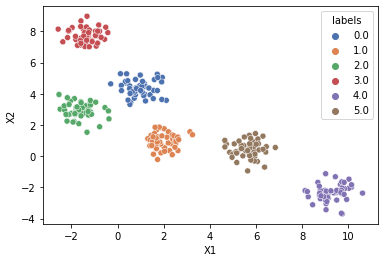

In [35]:
import typing
import dataclasses

X, y = datasets.make_blobs(
    n_samples=300, centers=6, cluster_std=0.5, random_state=0
)
data = pd.DataFrame(
    data=np.concatenate((X, y.reshape(-1, 1)), axis=1),
    columns=["X1", "X2", "labels"],
)
fig, ax = plt.subplots()
sns.scatterplot(x='X1', y='X2', hue='labels', data=data, ax=ax, palette='deep')

In [55]:
def bincount2d(x):
    N = x.max() + 1
    ids = x + (N * np.arange(x.shape[0]))[:, None]
    return np.bincount(ids.ravel(), minlength=N * x.shape[0]).reshape(-1, N)

@dataclasses.dataclass
class KNN:
    k: int
    metric: typing.Callable[[np.array], np.array]

    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X):
        assert hasattr(self, "X"), "fit method should be called before predicting!"
        distances = self.metric(self.X, X)
        labels_indices = np.argsort(distances, axis=0)[: self.k]
        labels = y[labels_indices]
        frequencies = bincount2d(labels.T)
        return np.argmax(frequencies, axis=1)


In [ ]:
clf = KNN(k=3, metric=scipy.spatial.distance.cdist)
clf.fit(X, y)
clf.predict([[1, 2], [3, 4]])


<AxesSubplot:xlabel='X1', ylabel='X2'>

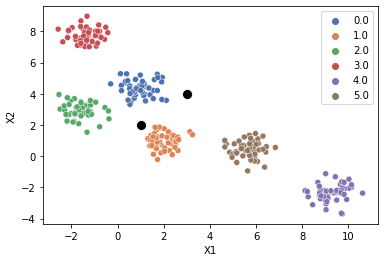

In [54]:
fig, ax = plt.subplots()
sns.scatterplot(x='X1', y='X2', hue='labels', data=data, ax=ax, palette='deep')
sns.scatterplot(x=[1, 3], y=[2, 4], ax=ax, color='black', s=100)

In [56]:
def _weighted_frequencies(result_array, labels, weights):
    for row in range(labels.shape[0]):
        for column in range(labels.shape[1]):
            result_array[row, labels[row, column]] += weights[row, column]

    return result_array


class WeightedKNN(KNN):
    def predict(self, X):
        distances = self.metric(self.X, X)
        labels_indices = np.argsort(distances, axis=0)[: self.k]
        labels = y[labels_indices].T
        weights = 1 / (np.sort(distances, axis=0)[: self.k] + 1e-7).T
        result_array = np.zeros((labels.shape[0], np.max(labels) + 1))
        w_frequencies = _weighted_frequencies(result_array, labels, weights)
        return np.argmax(w_frequencies, axis=1)


clf = WeightedKNN(k=3, metric=scipy.spatial.distance.cdist)
clf.fit(X, y)
clf.predict([[1, 2], [3, 4]])


array([1, 0])